# *Trabalho de Aprendizagem Não Supervisionada*
### **Objetivo**: 
Com uma base de fotos de pessoas de diferentes famílias, baseado em um arquivo que informa o parentesco entre elas, treinar uma rede para receber fotos, de duas em duas, e informar se essas pessoas são parentes (1) ou não (0). 

### **Integrantes**:
- Christian Sommer Bueno (1831143062) 
- Cleber Coradeli (1831143036)
- Fábio Rogerio Zilli (1831143063)
- Guilherme Alves Milreu (1831143045)
- Rodrigo Mendes de Faria (1831143029)

In [0]:
#Importando as blibliotecas
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
from PIL import Image
from keras import backend as K
import keras
from keras.models import Model
from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dropout, Activation
import random
from tqdm import tqdm_notebook

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
#Lendo o arquivo de treinamento que informa se as pessoas, dentro das pastas das famílias, são parentes. 
#Ex.: a pessoa que possui fotos dentro da pasta F0002/MID1 é parente da pessoa com fotos dentro da pasta F0002/MID3
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projeto_Aprendizagem_N_Superv_1/train_relationships.csv')
train.head()

,p1,p2
0,F0002/MID1,F0002/MID3
1,F0002/MID2,F0002/MID3
2,F0005/MID1,F0005/MID2
3,F0005/MID3,F0005/MID2
4,F0009/MID1,F0009/MID4


In [0]:
#Carregando a base de fotos de treinamento
TRAIN_BASE = '/content/drive/My Drive/Colab Notebooks/Projeto_Aprendizagem_N_Superv_1/train/'
families = sorted(os.listdir(TRAIN_BASE))
print('São {} famílias no dataset'.format(len(families)))
print(families[:5])

São 470 famílias no dataset
['F0002', 'F0005', 'F0009', 'F0010', 'F0016']


In [0]:
#Carregando os membros da família na variável members
members = {i:sorted(os.listdir(TRAIN_BASE+i)) for i in families}

In [0]:
#Carregando a base de testes
TEST_BASE='/content/drive/My Drive/Colab Notebooks/Projeto_Aprendizagem_N_Superv_1/test/'
test_images_names = os.listdir(TEST_BASE)
test_images_names[:5]

['face05280.jpg',
 'face05279.jpg',
 'face05281.jpg',
 'face05285.jpg',
 'face05286.jpg']

In [0]:
def load_img(PATH): return np.array(Image.open(PATH))

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

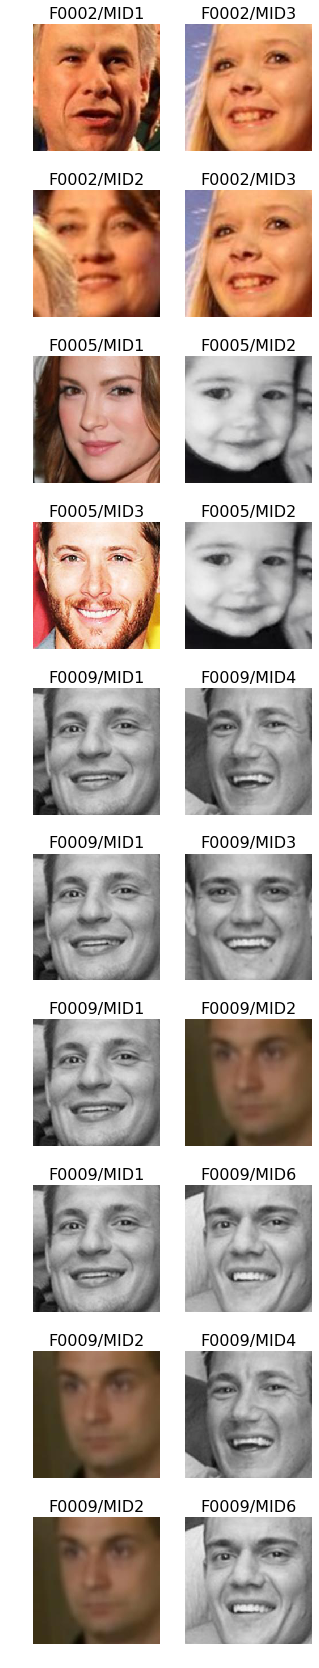

In [0]:
#Mostrando algumas fotos
def plot_relations(df, BASE='/content/drive/My Drive/Colab Notebooks/Projeto_Aprendizagem_N_Superv_1/train/', rows=1, titles=None):
    tdf = df[:rows]
    tdf1 = tdf.p1
    tdf2 = tdf.p2
    figsize=(5,3*rows)
    f = plt.figure(figsize=figsize)
    x = 0
    for i in range(rows):
        sp = f.add_subplot(rows, 2, x+1)
        sp.axis('Off')
        x+=1
        image_path = os.path.join(BASE,tdf1[i])
        im = os.listdir(image_path)[-1]
        sp.set_title(tdf1[i], fontsize=16)
        plt.imshow(load_img(os.path.join(image_path, im)))
        sp = f.add_subplot(rows, 2, x+1)
        x+=1
        sp.axis('Off')
        image_path = os.path.join(BASE,tdf2[i])
        im = os.listdir(image_path)[-1]
        sp.set_title(tdf2[i], fontsize=16)
        plt.imshow(load_img(os.path.join(image_path, im)))
        
plot_relations(train, rows=10)

In [0]:
test_images=np.array([load_img(os.path.join(TEST_BASE,image)) for image in test_images_names])

In [0]:
K.set_image_data_format('channels_first')

In [0]:
#Construindo o modelo utilizando o modelo pré-treinado VGG
def vgg_face(weights_path=None):
    img = Input(shape=(3, 224, 224))

    pad1_1 = ZeroPadding2D(padding=(1, 1))(img)
    conv1_1 = Convolution2D(64, (3, 3), activation='relu', name='conv1_1')(pad1_1)
    pad1_2 = ZeroPadding2D(padding=(1, 1))(conv1_1)
    conv1_2 = Convolution2D(64, (3, 3), activation='relu', name='conv1_2')(pad1_2)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2))(conv1_2)

    pad2_1 = ZeroPadding2D((1, 1))(pool1)
    conv2_1 = Convolution2D(128, (3, 3), activation='relu', name='conv2_1')(pad2_1)
    pad2_2 = ZeroPadding2D((1, 1))(conv2_1)
    conv2_2 = Convolution2D(128, (3, 3), activation='relu', name='conv2_2')(pad2_2)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2))(conv2_2)

    pad3_1 = ZeroPadding2D((1, 1))(pool2)
    conv3_1 = Convolution2D(256, (3, 3), activation='relu', name='conv3_1')(pad3_1)
    pad3_2 = ZeroPadding2D((1, 1))(conv3_1)
    conv3_2 = Convolution2D(256, (3, 3), activation='relu', name='conv3_2')(pad3_2)
    pad3_3 = ZeroPadding2D((1, 1))(conv3_2)
    conv3_3 = Convolution2D(256, (3, 3), activation='relu', name='conv3_3')(pad3_3)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2))(conv3_3)

    pad4_1 = ZeroPadding2D((1, 1))(pool3)
    conv4_1 = Convolution2D(512, (3, 3), activation='relu', name='conv4_1')(pad4_1)
    pad4_2 = ZeroPadding2D((1, 1))(conv4_1)
    conv4_2 = Convolution2D(512, (3, 3), activation='relu', name='conv4_2')(pad4_2)
    pad4_3 = ZeroPadding2D((1, 1))(conv4_2)
    conv4_3 = Convolution2D(512, (3, 3), activation='relu', name='conv4_3')(pad4_3)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2))(conv4_3)

    pad5_1 = ZeroPadding2D((1, 1))(pool4)
    conv5_1 = Convolution2D(512, (3, 3), activation='relu', name='conv5_1')(pad5_1)
    pad5_2 = ZeroPadding2D((1, 1))(conv5_1)
    conv5_2 = Convolution2D(512, (3, 3), activation='relu', name='conv5_2')(pad5_2)
    pad5_3 = ZeroPadding2D((1, 1))(conv5_2)
    conv5_3 = Convolution2D(512, (3, 3), activation='relu', name='conv5_3')(pad5_3)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2))(conv5_3)

    fc6 = Convolution2D(4096, (7, 7), activation='relu', name='fc6')(pool5)
    fc6_drop = Dropout(rate = 0.5)(fc6)
    fc7 = Convolution2D(4096,( 1, 1), activation='relu', name='fc7')(fc6_drop)
    fc7_drop = Dropout(rate = 0.5)(fc7)
    fc8 = Convolution2D(2622, (1, 1), name='fc8')(fc7_drop)
    flat = Flatten()(fc8)
    out = Activation('softmax')(flat)

    model = Model(input=img, output=out)

    if weights_path:
        model.load_weights(weights_path)

    return model

In [0]:
vgg_facenet = vgg_face('/content/drive/My Drive/Colab Notebooks/Projeto_Aprendizagem_N_Superv_1/vgg-face-keras.h5')

W0615 17:39:43.485984 140313744496512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0615 17:39:43.543676 140313744496512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0615 17:39:43.576823 140313744496512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0615 17:39:43.596221 140313744496512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0615 17:39:43.598250 1403137444

In [0]:
vgg_facenet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

In [0]:

test_images = os.listdir(TEST_BASE)
test = np.array([load_img(os.path.join(TEST_BASE, i)) for i in test_images])
test_emb = vgg_facenet.predict(test.transpose(0,3,1,2))
print(test.shape, test_emb.shape)

(6282, 224, 224, 3) (6282, 2622)


In [0]:
image_mapping = {img:idx for idx, img in enumerate(test_images)}

In [0]:
# Lendo a planilha dentro do arquivo submission
submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Projeto_Aprendizagem_N_Superv_1/sample_submission.csv')
req_mapping = [i.split('-') for i in submission.img_pair]

In [0]:
def distance(x, y):
    return np.linalg.norm(x - y)

In [0]:
vector_distances=[]
for i in req_mapping:
    a = i[0]
    b = i[1]
    dis = distance(test_emb[image_mapping[a]], test_emb[image_mapping[b]])
    vector_distances.append(dis)
vector_distances=np.array(vector_distances)

In [0]:
total_sum = vector_distances.sum()

In [0]:
#Escolhemos que, se o resultado é menor que 0.7, então não considera que são parentes, ou seja, fica com '0' no arquivo. Caso contrário, fica com '1'
probs = []
for dist in vector_distances:
    prob = np.sum(vector_distances[np.where(vector_distances <= dist)[0]])/total_sum
    
    if (1 - prob) <= 0.7:
        probs.append(0)
    else:
        probs.append(1)
   

In [0]:
# Movendo a área que está em probabilidade para a coluna is_related da variável submission
submission.is_related = probs

In [0]:
# Gravando o resultado das probabilidades calculadas no arquivo submission.csv
submission.to_csv('/content/drive/My Drive/Colab Notebooks/Projeto_Aprendizagem_N_Superv_1/submission.csv', index=False)

In [0]:
submission.head(30)

# **Conclusão**: Conseguimos extrair as características das imagens, utilizando convolução, através da rede pré-treinada VGG. Após isso, subtraindo uma imagem da outra, quanto mais próximo de zero o resultado, maior semelhança elas tem, ou seja, a chance de ser parentes é grande. Nossa submissão no Kaggle ficou em 52,00%